This notebook illustrate how to generate fringing in real LSST sky background using the derived sensor thickness map and background spectra

In [1]:
from LSSTFringe import Sky   
from LSSTFringe import utils,plot_utils
%pylab inline
import lsst.sims.utils.ObservationMetaData as ObsMeta 
import galsim
import warnings
import astropy.units as u
warnings.filterwarnings('ignore')

plot_utils.init_plot_style()

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load thickness map and interpolator
Fitting,uu,indices = utils.load_ccd_map('E2V-321')
pfs_interpolator = utils.load_interp(experiment='LSST')
Normal_interpolator = utils.load_interp(experiment='Normal')
Mono_interpolator = utils.load_interp(experiment='Mono')
sky_interpolator = utils.load_interp(experiment='sky')
sky_mono_interpolator = utils.load_interp(experiment='sky_mono')

In [3]:
Obs_meta = ObsMeta(pointingRA=5.497787143782138,
                   pointingDec=-1.519759751642230,bandpassName='y',rotSkyPos=0)

model = Sky.Sky(ra=Obs_meta.pointingRA,dec = Obs_meta.pointingDec,Mjd=58000)  

# Split sky background into two components
upperatm_count,up_wlen,up_spec = model.Count_upper_atm()
contiuum_count = model.Count_sky_continuum()

In [4]:
photParams = model.Phot_par()
exposureTime = photParams.nexp*photParams.exptime

upper_count = upperatm_count*exposureTime
# Adding noise to sky background
randomNum = galsim.UniformDeviate()
noise = galsim.CCDNoise(randomNum,sky_level=0.0,gain=photParams.gain,read_noise=photParams.readnoise)

# Making a galsim image for sky bg & upper Atm
image_cont = np.ones(shape = (3974,4000))*contiuum_count*exposureTime
galsim_image_cont = galsim.Image(image_cont, copy=True)

image_UpperAtm = np.ones(shape = (3974,4000))*upperatm_count*exposureTime
galsim_image_UpperAtm = galsim.Image(image_UpperAtm, copy=True)

# Adding noise to images
galsim_image_cont.addNoise(noise)
galsim_image_UpperAtm.addNoise(noise)

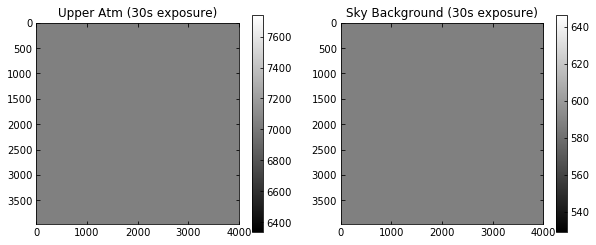

In [5]:
f,ax = plt.subplots(ncols=2,figsize =(10,4))
im1 = ax[0].imshow(image_UpperAtm,cmap='gray')
ax[0].set_title('Upper Atm (%is exposure)'%exposureTime)
im2 = ax[1].imshow(image_cont,cmap='gray')
ax[1].set_title('Sky Background (%is exposure)'%exposureTime)
f.colorbar(im1,ax=ax[0])
f.colorbar(im2,ax=ax[1]);

In [45]:


yband_QE = Sky.Sky().Bandpass()
yband = Sky.Sky().Bandpass()
detector = Sky.Sky().detector_throughputs()
yband.sb = yband.sb/detector
where_are_NaNs = isnan(yband.sb)
yband.sb[where_are_NaNs] = 0
mm = (yband.wavelen < 1100) & (yband.wavelen > 908)

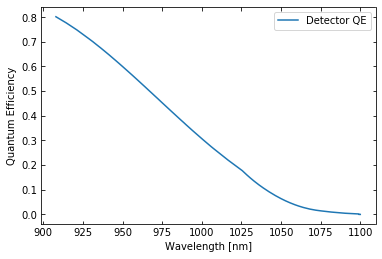

In [60]:
plt.plot(yband.wavelen[mm],detector[mm],label = 'Detector QE')
plt.legend()
plt.ylabel('Quantum Efficiency')
plt.xlabel('Wavelength [nm]');

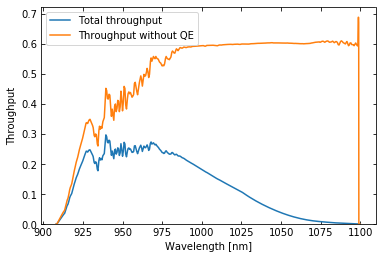

In [59]:

plt.plot(yband.wavelen[mm],yband_QE.sb[mm],label = 'Total throughput')
plt.plot(yband.wavelen[mm],yband.sb[mm],label = 'Throughput without QE')
plt.ylim(0,)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Throughput')
plt.legend();

In [6]:
def line_under_bandpass (PFS = False,Skybrightness = False,verbose = True):
    
    detector = Sky.Sky().detector_throughputs()
    yband = Sky.Sky().Bandpass()
    
    yband.sb = yband.sb/detector
    where_are_NaNs = isnan(yband.sb)
    yband.sb[where_are_NaNs] = 0
    
    if PFS == True: 
    
        line_wlen,line_int,l =Sky.OHlines().load_skyline()
        _,group_dir = Sky.OHlines().get_grouping(l)
        mask = (line_wlen > 908) & (line_wlen < 1099)
        
        c = Sky.Conv(band_wlen=yband.wavelen,band_thr=yband.sb,line_wlen=line_wlen,line_int=line_int)
        intensity = c.conv()
        #line_intensity = intensity/np.sum(intensity)
        
        wavelengths = np.round(line_wlen[mask],1)
        line_intensity = intensity*wavelengths/np.sum(intensity*wavelengths)
        line_count = upper_count*line_intensity 
        
        if verbose == True:
            print(line_count.shape)
        
    if Skybrightness == True:
        
        m = (up_wlen > 908.3) & (up_wlen < 1098.8)

        c = Sky.Conv(band_wlen=yband.wavelen,band_thr=yband.sb,line_wlen=up_wlen[m],line_int=up_spec[0][m])
        intensity = c.conv()
        
        wavelengths = np.round(up_wlen[m],1)
        line_intensity = intensity*wavelengths/np.sum(intensity*wavelengths)
        line_count = upper_count*line_intensity   
        
        if verbose == True:
            print(line_count.shape)
    
    return(wavelengths,line_count)

In [7]:
def plot_line (wavelen, intensity , color):
    for i in range(len(wavelen)):
        plt.plot([wavelen[i],wavelen[i]],[0,intensity[i]],color = 'black')
    plt.ylim(0,)

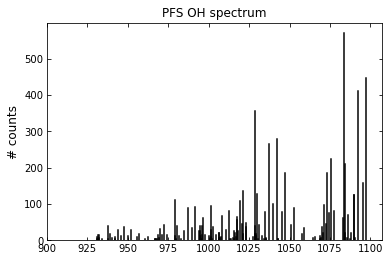

In [8]:
PFS_wavelengths, PFS_line_count = line_under_bandpass (PFS = True,verbose=False)
plot_utils.plot_line(PFS_wavelengths,PFS_line_count,'black')
plt.ylabel('# counts',fontsize = 12)
plt.title('PFS OH spectrum');

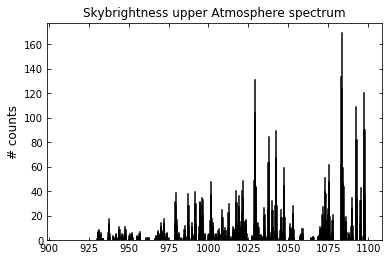

In [9]:
sky_wavelengths, sky_line_count = line_under_bandpass (Skybrightness= True,verbose=False)
plot_utils.plot_line(sky_wavelengths,sky_line_count,'black')
plt.ylabel('# counts',fontsize = 12)
plt.title('Skybrightness upper Atmosphere spectrum');

In [10]:
def sim (wavelengths,line_count,interp,angles,angle_weight):
    sim_res = np.zeros(shape = Fitting.shape)
    for wlen,count_num in zip(wavelengths,line_count):
        int_f = interp[str(wlen)]
        ss = int_f(uu,angles)
        sst = ss.T
        total = np.sum(sst * angle_weight, axis = 1)
        final = total[indices]
        sim_res += count_num*final.reshape(3974,4000)
        
    return(sim_res)

In [11]:
# Incident angle distribution and corresponding weight
angles_center,weight_center = utils.get_angle(theta_x=0,theta_y=0.)
angles_edge,weight_edge = utils.get_angle(theta_x=1.2,theta_y=0.8)

# MonoCam angle distribution
th_min=0.1*u.deg 
th_max=7.13*u.deg

angles_mono = np.linspace(th_min.to(u.rad).value, th_max.to(u.rad).value, 100)
weight_mono = angles_mono / np.sum(angles_mono)

In [12]:
# Define some plotting utility functions
def plot_tt_amp (sim_res,l):
    tt = sim_res + image_cont
    plt.plot(np.diag(tt/np.mean(tt)-1)*100,label = l)
    plt.legend()
    plt.axhline(0,ls = '--',color = 'black')
    plt.ylabel('Fringing amplitude (%)',fontsize = 12)  

def plot_diag (sim):
    plt.plot((np.diag(sim)/np.mean(np.diag(sim))-1)*100)
    
def bg_image (sim_res,image_count = image_cont):
    galsim_image = galsim.Image(sim_res+image_count, copy=True)
    galsim_image.addNoise(noise)
    plt.imshow(galsim_image.array,cmap = 'gray',origin = 'lower')
    plt.colorbar()

In [13]:
# Generate simluations based on the two OH spectrum for two locations on the LSST focal plane, this may take a while (These are all 4kx4k images!).

# Focal plane center
sim_pfs_center = sim(wavelengths=PFS_wavelengths,line_count=PFS_line_count,interp= pfs_interpolator,angles = angles_center, angle_weight=weight_center)
sim_sky_center = sim(wavelengths=sky_wavelengths,line_count=sky_line_count,interp= sky_interpolator,angles = angles_center, angle_weight=weight_center)

# Focal plane edge
sim_pfs_edge = sim(wavelengths=PFS_wavelengths,line_count=PFS_line_count,interp= pfs_interpolator,angles = angles_edge, angle_weight=weight_edge)
sim_sky_edge = sim(wavelengths=sky_wavelengths,line_count=sky_line_count,interp= sky_interpolator,angles = angles_edge, angle_weight=weight_edge)

# MonoCam setup
mono_pfs = sim(wavelengths=PFS_wavelengths,line_count=PFS_line_count,interp= Mono_interpolator,angles = angles_mono, angle_weight=weight_mono)
mono_sky = sim(wavelengths=sky_wavelengths,line_count=sky_line_count,interp= sky_mono_interpolator,angles = angles_mono, angle_weight=weight_mono)

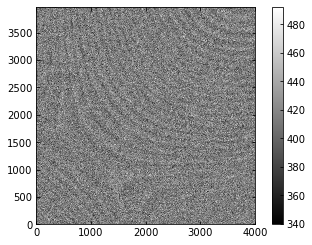

In [26]:
galsim_image = galsim.Image(mono_pfs, copy=True)
galsim_image.addNoise(noise)
plt.imshow(galsim_image.array,cmap = 'gray',origin = 'lower')
plt.colorbar()

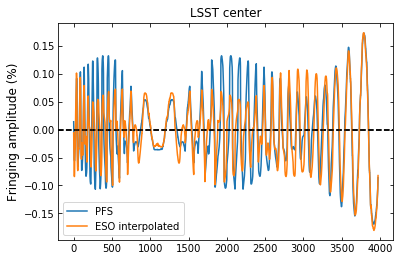

In [14]:
# Plotting the diagnal components for comparison.
plt.title('LSST center',fontsize = 12)
plot_tt_amp(sim_pfs_center,l = 'PFS')
plot_tt_amp(sim_sky_center,l = 'ESO interpolated')

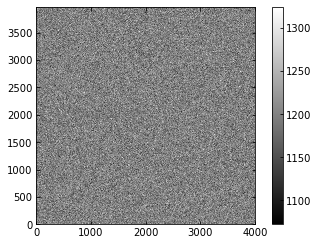

In [29]:
bg_image(sim_res=sim_pfs_center)

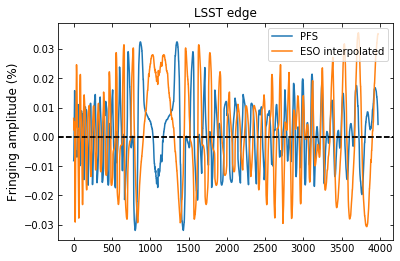

In [16]:
plt.title('LSST edge',fontsize = 12)
plot_tt_amp(sim_pfs_edge,l = 'PFS')
plot_tt_amp(sim_sky_edge,l = 'ESO interpolated')

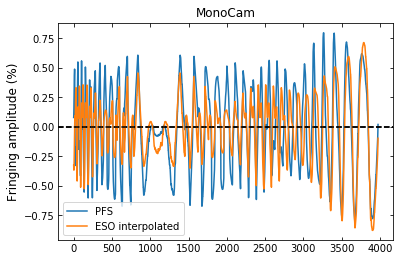

In [17]:
# Plotting the diagnal components for comparison.
plt.title('MonoCam',fontsize = 12)
plot_tt_amp(mono_pfs,l = 'PFS')
plot_tt_amp(mono_sky,l = 'ESO interpolated')

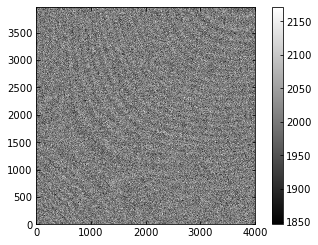

In [27]:
bg_image(sim_res=mono_pfs*2,image_count=image_cont*2)

Select an individual vibrational group for simulation. 

This is only available for PFS data. Since the lines are from Rousselout, which claims to have accurracy to in 1e-5

In [20]:
s = Sky.OHlines()
print(s.vib_group)

def OH_group (group_id,verbose = False):
    
    line_wlen,line_int,l =Sky.OHlines().load_skyline()
    _,group_dir = Sky.OHlines().get_grouping(l)
    wlen,inten,_ = s.get_line()
    mask = (line_wlen > 908) & (line_wlen < 1099)
    
    group_count = PFS_line_count[group_dir[group_id][mask]]
    group_wlen =PFS_wavelengths[group_dir[group_id][mask]]
    
    if verbose:
        print(group_wlen.shape,group_count.shape)
    group_sim = sim(wavelengths=group_wlen,line_count=group_count,interp= pfs_interpolator,angles = angles_center, angle_weight=weight_center)
    return(group_sim)

['7-3', '8-4', '3-0', '9-5', '4-1', '5-2', 'Unidentified']


In [21]:
center_30 = OH_group('3-0')

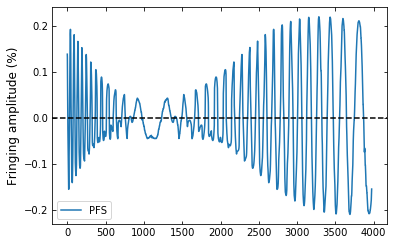

In [22]:
plot_tt_amp(center_30,l = 'PFS')

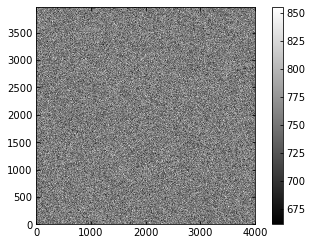

In [23]:
bg_image(center_30)

In [39]:
a,b

(array([909.5, 909.5, 910.5, 915.5, 916.3, 916.4, 921.9, 922.7, 922.8]),
 array([0.02071582, 0.03715695, 0.07774758, 0.05222416, 0.11709569,
        0.12067589, 0.0314137 , 0.05975402, 0.06026563]))

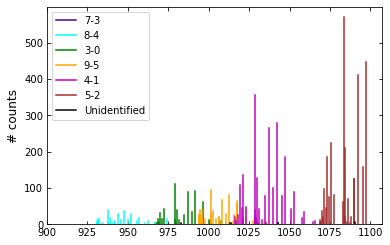

In [43]:
def OH_group_line (group_id,verbose = False):
    
    line_wlen,line_int,l =Sky.OHlines().load_skyline()
    _,group_dir = Sky.OHlines().get_grouping(l)
    wlen,inten,_ = s.get_line()
    mask = (line_wlen > 908) & (line_wlen < 1099)
    
    group_count = PFS_line_count[group_dir[group_id][mask]]
    group_wlen =PFS_wavelengths[group_dir[group_id][mask]]
    
    return(group_wlen,group_count)

colors = ['indigo','aqua','green','orange','m','brown','black']
for c,name in zip(colors,s.vib_group):
    a,b = OH_group_line(name)
    for i in range(len(a)):
        if i == 0:
            plt.plot([a[i],a[i]],[0,b[i]],color = c,label = name)

        plt.plot([a[i],a[i]],[0,b[i]],color = c)
plt.legend()
plt.ylabel('# counts',fontsize = 12)
plt.ylim(0,);